In [31]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from numba import cuda
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import random
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/AIE/dogs-vs-cats.zip'

In [4]:
!unzip -qq './test1.zip'

In [5]:
!unzip -qq './train.zip'

In [6]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
train_df = pd.DataFrame({"file": os.listdir("/content/dogs-vs-cats/train")})
train_df["label"] = train_df["file"].apply(lambda x: x.split(".")[0])

train_df.head()

file label
0  cat.4492.jpg   cat
1  cat.7175.jpg   cat
2  dog.5966.jpg   dog
3   dog.819.jpg   dog
4  cat.2203.jpg   cat

In [8]:
test_df = pd.DataFrame({"file": os.listdir("/content/dogs-vs-cats/test1")})

test_df.head()

file
0  1576.jpg
1  1942.jpg
2  4787.jpg
3  6536.jpg
4  7934.jpg

In [9]:
train_data, val_data = train_test_split(train_df,
                                        test_size = 0.2,
                                        stratify = train_df["label"],
                                        random_state = 13)

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range =15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
FILES = "./dogs-vs-cats/"
batch_size = 160
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = FILES + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224,224),
    batch_size = batch_size,
    seed = 13,
)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = FILES + "train/",
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224,224),
    batch_size = batch_size,
    seed = 13,
    shuffle = False
)

Found 5000 validated image filenames belonging to 2 classes.


In [14]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224,224,3),
    include_top = False
)

58889256/58889256 [==============================] - 4s 0us/step


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
for layers  in base_model.layers:
  layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
def vgg16_pretrained():

  model = Sequential(
      [
          base_model,
          GlobalAveragePooling2D(),
          Dense(100, activation = "relu"),
          Dropout(0.4),
          Dense(64, activation = "relu"),
          Dense(2, activation = "softmax")
      ]
  )

  return model

In [18]:
tf.keras.backend.clear_session()

In [21]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = "accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                        

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    patience = 2,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.000000001
)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max",
)

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True
)

In [25]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_data.shape[0] // batch_size,
    steps_per_epoch = train_data.shape[0] // batch_size,
    callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9372
Epoch 1: val_accuracy improved from -inf to 0.97560, saving model to catdog_vgg16_.01-0.975605.hdf5
125/125 [==============================] - 362s 3s/step - loss: 0.2294 - accuracy: 0.9372 - val_loss: 0.0615 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9733
Epoch 2: val_accuracy improved from 0.97560 to 0.97883, saving model to catdog_vgg16_.02-0.978831.hdf5
125/125 [==============================] - 329s 3s/step - loss: 0.0760 - accuracy: 0.9733 - val_loss: 0.0520 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9766
Epoch 3: val_accuracy improved from 0.97883 to 0.97984, saving model to catdog_vgg16_.03-0.979839.hdf5
125/125 [==============================] - 331s 3s/step - loss: 0.0635 - accuracy: 0.9766 - val_loss: 0.0497 - val_a

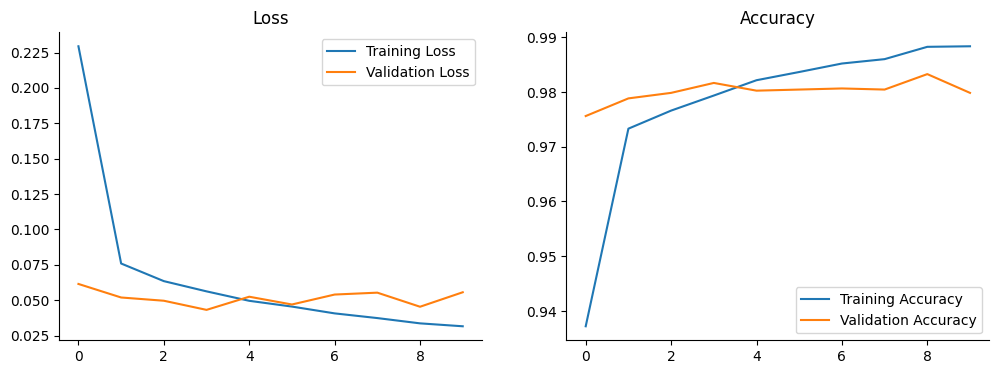

In [29]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"], ax = axes[0],
             label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"], ax = axes[0],
             label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"], ax = axes[1],
             label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"], ax = axes[1],
             label = "Validation Accuracy")
axes[0].set_title("Loss");axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [30]:
val_pred = model.predict(val_generator,
                         steps = np.ceil(val_data.shape[0] / batch_size))
val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis = 1)

labels = dict((v, k) for k, v in val_generator.class_indices.items())

val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

32/32 [==============================] - 33s 1s/step


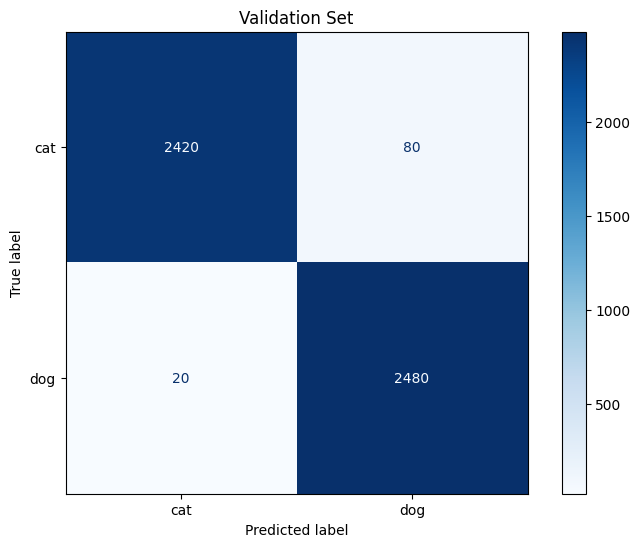

In [33]:
fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cat", "dog"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()

In [34]:
val_errors = val_data[(val_data.label) != (val_data.val_pred)].reset_index(drop = True)
val_errors

file label val_pred
0   dog.1094.jpg   dog      cat
1   cat.3532.jpg   cat      dog
2   cat.3191.jpg   cat      dog
3   dog.1815.jpg   dog      cat
4   cat.9410.jpg   cat      dog
..           ...   ...      ...
95  cat.5149.jpg   cat      dog
96  dog.6910.jpg   dog      cat
97  dog.5563.jpg   dog      cat
98  cat.1423.jpg   cat      dog
99  cat.9589.jpg   cat      dog

[100 rows x 3 columns]

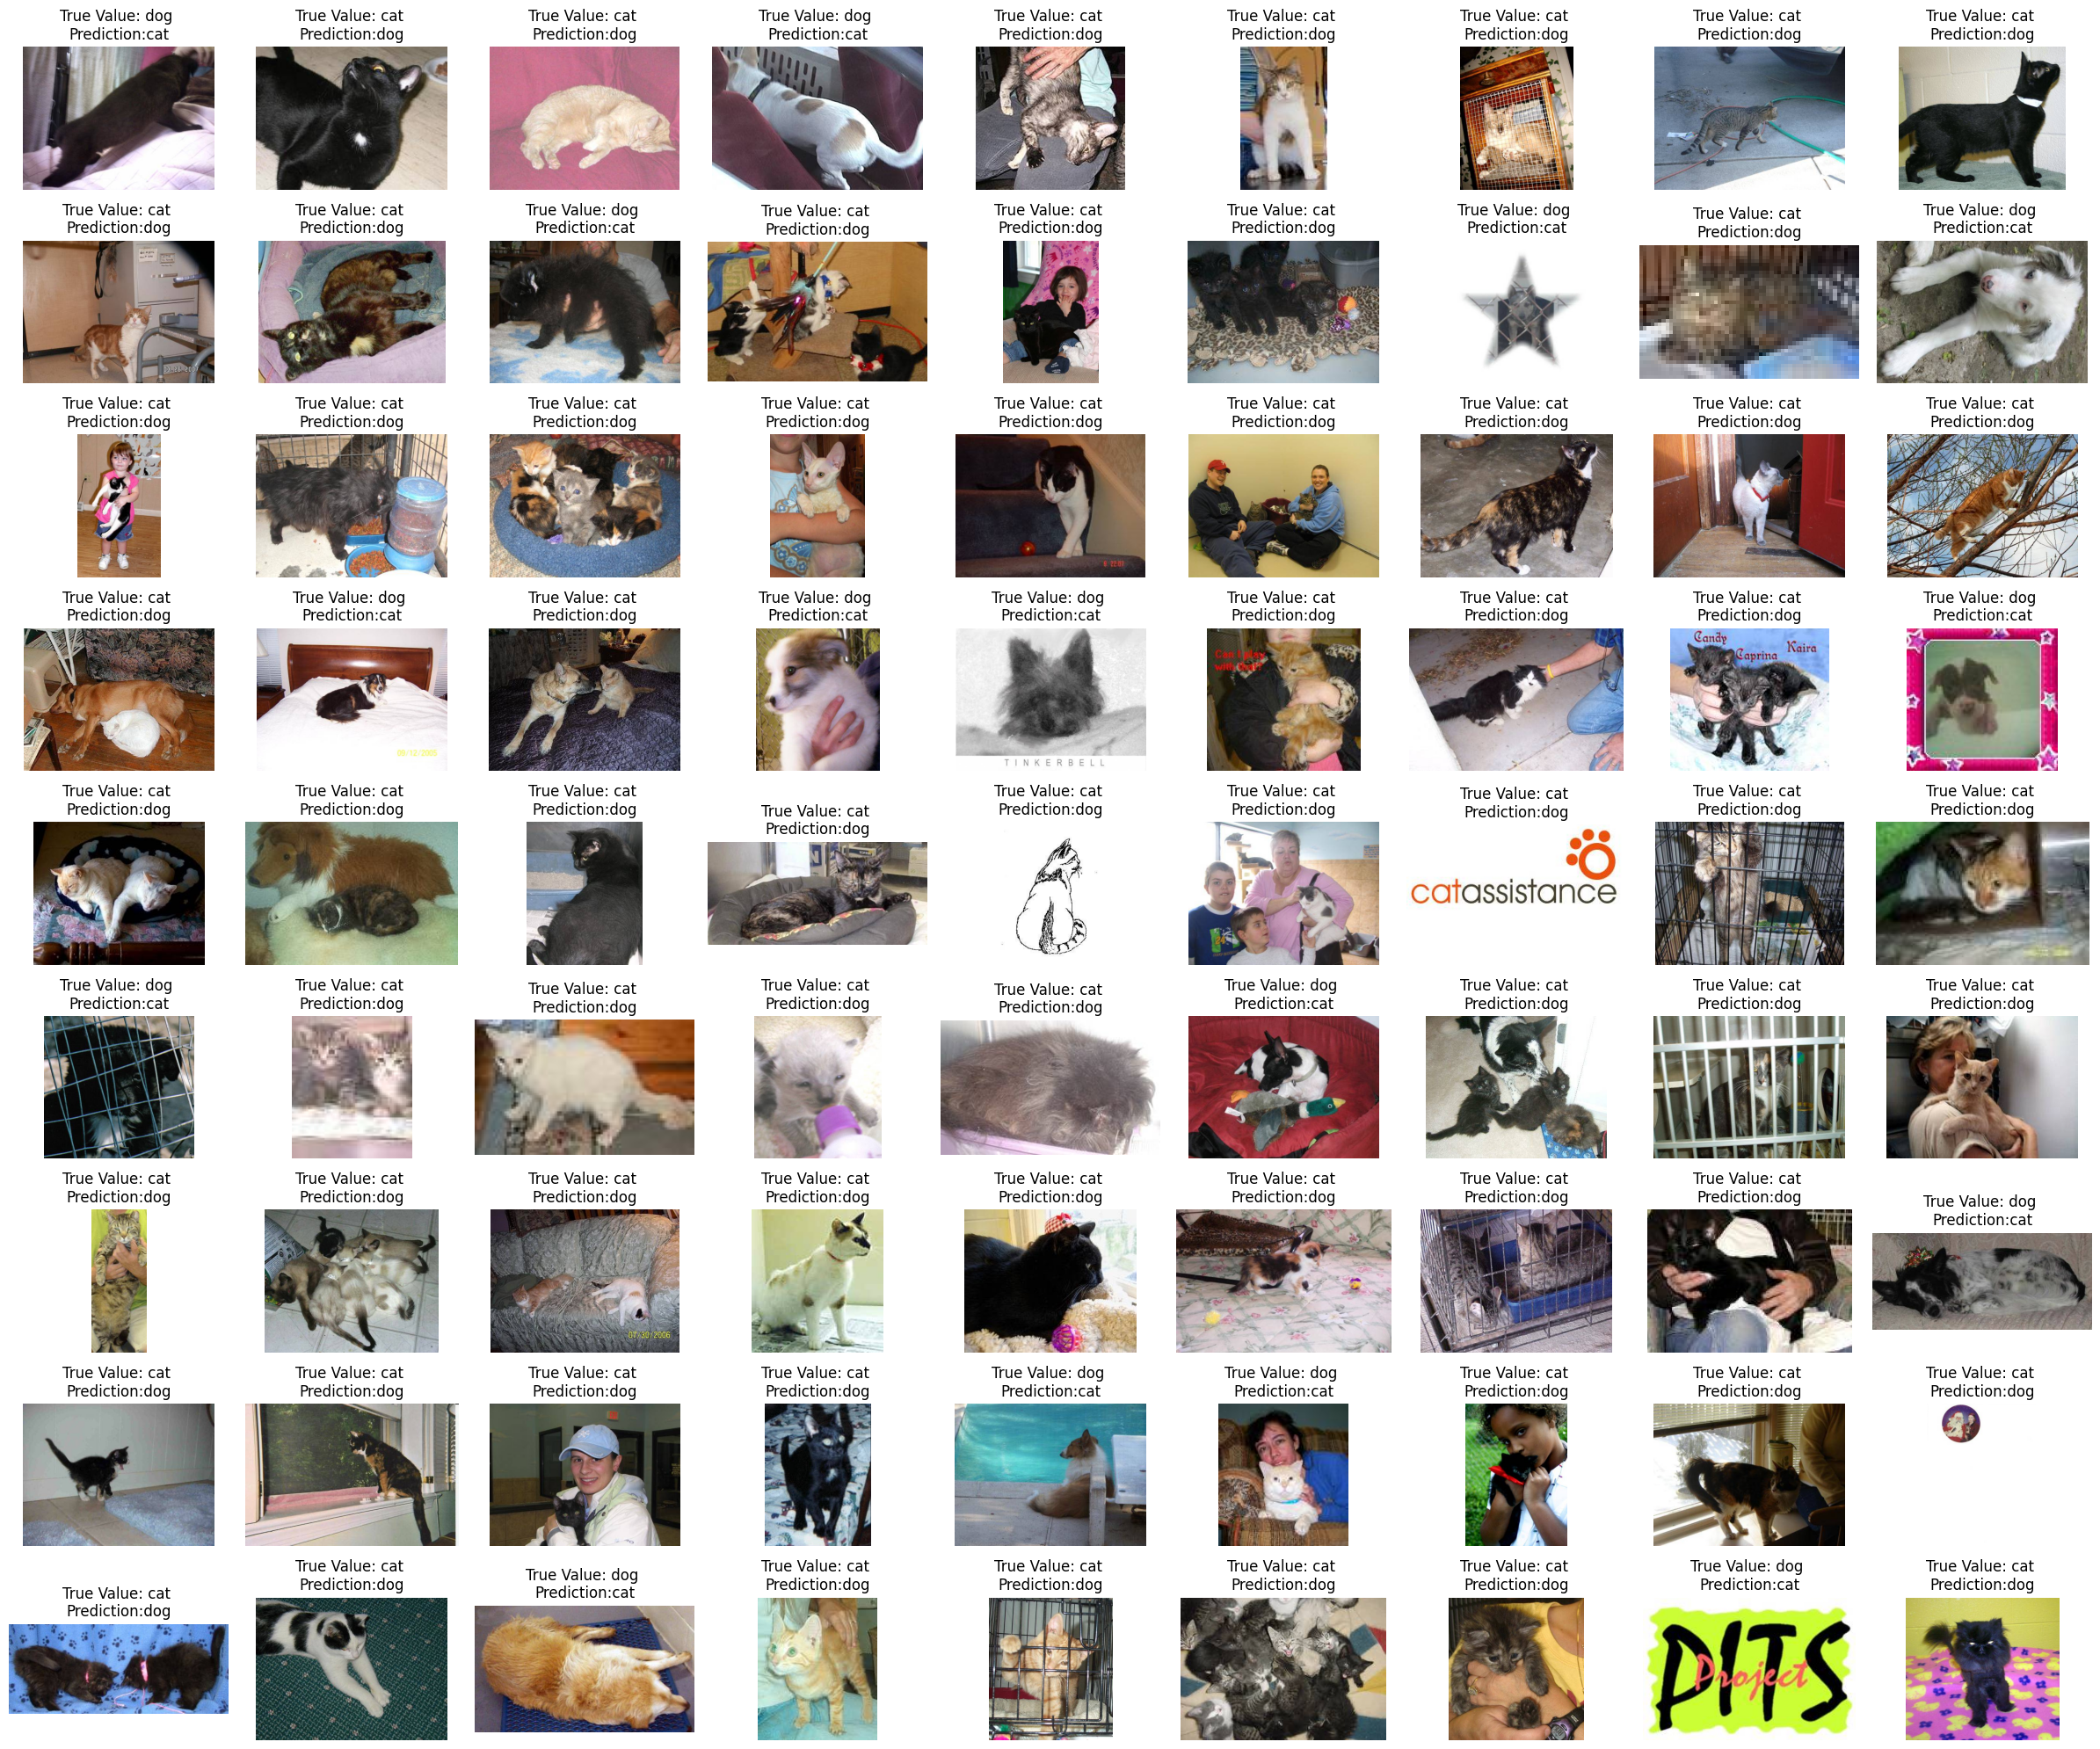

In [38]:
fig = plt.figure(1, figsize = (24,20))

for i in range(81):
  if i == len(val_errors):
    break
  plt.subplot(9,9,i+1)
  image = plt.imread("./dogs-vs-cats/train/" + val_errors.file[i])
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"True Value: {val_errors['label'][i]} \nPrediction:{val_errors['val_pred'][i]}")

plt.tight_layout()
plt.show()